In [72]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [73]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [74]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [75]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [76]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [77]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [78]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [79]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [80]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement).order_by(Measurement.date.desc()).first()
most_recent.date

'2017-08-23'

2016-08-23 00:00:00


<AxesSubplot:xlabel='Date', ylabel='Inches'>

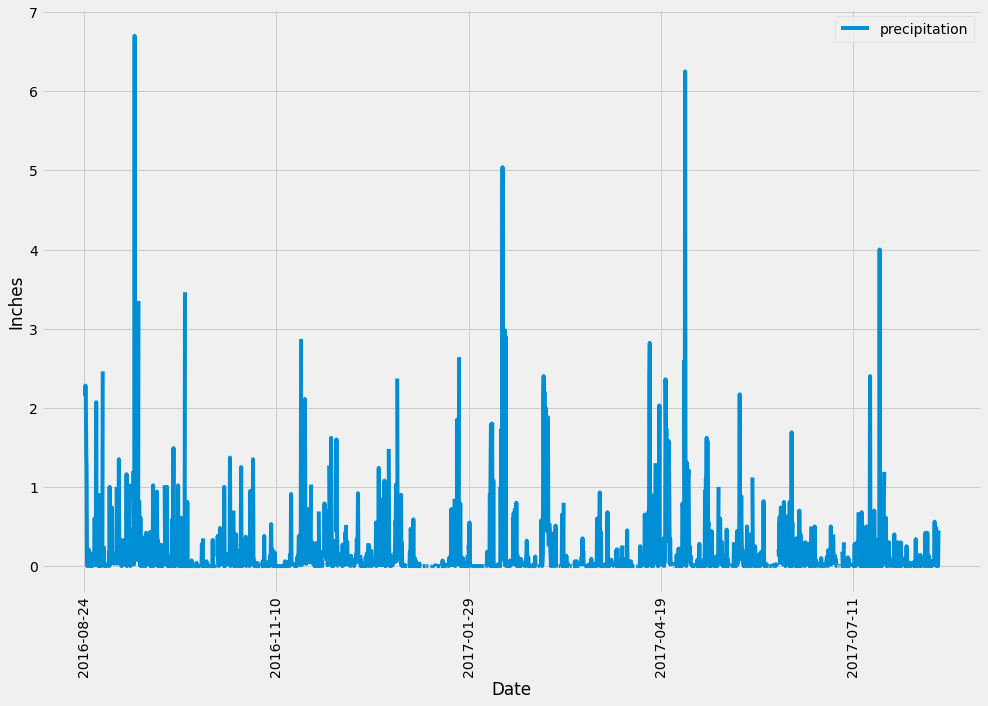

In [81]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent.date, '%Y-%m-%d') - dt.timedelta(days=365)
# one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
previous_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_prcp_df = pd.DataFrame(previous_year_prcp)
last_year_prcp_df.rename(columns={'prcp': 'precipitation'}, inplace=True)
# Sort the dataframe by date
sorted_last_prcp = last_year_prcp_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
sorted_last_prcp.plot("date","precipitation",xlabel="Date" ,ylabel="Inches",figsize=(15, 10),rot=90)



In [82]:
# Use Pandas to calcualte the summary statistics for the precipitation data
mean_data = sorted_last_prcp.groupby("date").mean().reset_index()
median_data = sorted_last_prcp.groupby("date").median().reset_index()
var_data = sorted_last_prcp.groupby("date").var().reset_index()
std_data = sorted_last_prcp.groupby("date").std().reset_index()
sem_data = sorted_last_prcp.groupby("date").sem().reset_index()

mean_median = pd.merge(mean_data,median_data,how="left", on="date")
mean_median.rename(columns={"precipitation_x":"Mean Precipitation","precipitation_y":"Median Precipitation"}, inplace=True)

add_var = pd.merge(mean_median,var_data,how="left", on="date")
add_var.rename(columns={"precipitation":"Precipitation Variance"}, inplace=True)

add_std = pd.merge(add_var,std_data,how="left", on="date")
add_std.rename(columns={"precipitation":"Precipitation Std. Dev."}, inplace=True)

agg_data = pd.merge(add_std,sem_data,how="left", on="date")
agg_data.rename(columns={"precipitation":"Precipitation Std. Err."}, inplace=True)


agg_data

,date,Mean Precipitation,Median Precipitation,Precipitation Variance,Precipitation Std. Dev.,Precipitation Std. Err.
0,2016-08-24,1.555000,1.800,0.706510,0.840541,0.343150
1,2016-08-25,0.077143,0.080,0.005157,0.071813,0.027143
2,2016-08-26,0.016667,0.015,0.000267,0.016330,0.006667
3,2016-08-27,0.064000,0.020,0.006680,0.081731,0.036551
4,2016-08-28,0.516667,0.140,0.620427,0.787672,0.321566
...,...,...,...,...,...,...
360,2017-08-19,0.030000,0.000,0.002700,0.051962,0.030000
361,2017-08-20,0.005000,0.005,0.000050,0.007071,0.005000
362,2017-08-21,0.193333,0.020,0.100933,0.317700,0.183424
363,2017-08-22,0.166667,0.000,0.083333,0.288675,0.166667


# Exploratory Station Analysis

In [83]:
# Design a query to calculate the total number stations in the dataset
engine.execute('select count(*) from station').fetchall()

[(9,)]

In [84]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = engine.execute('select station, count(*) from measurement group by station order by count(*) desc').fetchall()
print(station_activity)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [85]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station =station_activity[0][0]
engine.execute(f'select station, min(tobs) as min_temp, max(tobs) as max_temp, avg(tobs) as avg_temp from measurement where station = "{most_active_station}" group by station').fetchall()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

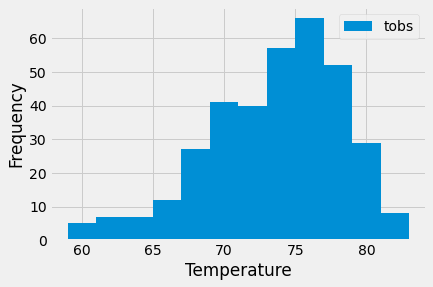

In [86]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temps = engine.execute(f'select tobs from measurement where station = "{most_active_station}" and date > "{one_year_ago}" order by date').fetchall()

USC00519281_last_year = pd.DataFrame(last_year_temps)
USC00519281_last_year.plot.hist(grid=True, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')


# Close session

In [104]:
# Close Session
session.close()